In [38]:
import boto3
import pandas as pd
import numpy as np
import io
import sys
import os
import seaborn as sns
# local libraries
sys.path.append(os.path.abspath(os.path.join(sys.path[0], '..', 'src', 'lib')))
import athena_connect
import market_maker_training

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
%matplotlib inline

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import datetime
from datetime import timedelta

(datetime.datetime.utcnow() - timedelta(days=10)).strftime("%Y-%m-%d")
#datetime.datetime.utcnow().strftime("%Y-%m-%d")

'2018-08-28'

# "Market Maker" Model Development

In [39]:
def features(feature_minutes_list, trade_window_list=[5]):
    #TODO: move this config to simulation argument 
    coin_pair_dict = {'target':'btcusdt',
                      'alt':'ethusdt'}
    print(f"Coin feature configuration: {coin_pair_dict}")

    mm_training = market_maker_training.BinanceTraining(coin_pair_dict, feature_minutes_list, trade_window_list)
    try:
        mm_training.set_training_data()
    except Exception as e:
        print(f"Failed setting training data: {e}")
        return
    return mm_training.training_df, mm_training.feature_column_list, mm_training.target_column_list

feature_minutes_list = [1,3,5,10,20,30,40,50,60,120,240,480,960]
#feature_minutes_list = [1,5]
features_df, feature_col, target_col_list = features(feature_minutes_list)
features_df.tail(20)

Coin feature configuration: {'target': 'btcusdt', 'alt': 'ethusdt'}
(40218, 322)
(39258, 322)


btcusdt_trade_datetime btcusdt_trade_date  btcusdt_trade_minute  \
40198 2018-11-02 11:29:00+00:00         2018-11-02              25685969   
40199 2018-11-02 11:30:00+00:00         2018-11-02              25685970   
40200 2018-11-02 11:31:00+00:00         2018-11-02              25685971   
40201 2018-11-02 11:32:00+00:00         2018-11-02              25685972   
40202 2018-11-02 11:33:00+00:00         2018-11-02              25685973   
40203 2018-11-02 11:34:00+00:00         2018-11-02              25685974   
40204 2018-11-02 11:35:00+00:00         2018-11-02              25685975   
40205 2018-11-02 11:36:00+00:00         2018-11-02              25685976   
40206 2018-11-02 11:37:00+00:00         2018-11-02              25685977   
40207 2018-11-02 11:38:00+00:00         2018-11-02              25685978   
40208 2018-11-02 11:39:00+00:00         2018-11-02              25685979   
40209 2018-11-02 11:40:00+00:00         2018-11-02              25685980   
40210 2018-11-02 11:41:00+00:00         2018-11-02              25685981   
40211 2018-11-02 11:42:00+00:00         2018-11-02              25685982   
40212 2018-11-02 11:43:00+00:00         2018-11-02              25685983   
40213 2018-11-02 11:44:00+00:00         2018-11-02              25685984   
40214 2018-11-02 11:45:00+00:00         2018-11-02              25685985   
40215 2018-11-02 11:46:00+00:00         2018-11-02              25685986   
40216 2018-11-02 11:47:00+00:00         2018-11-02              25685987   
40217 2018-11-02 11:48:00+00:00         2018-11-02              25685988   

       trade_day_of_week  trade_hour  btcusdt_bid_ask_spread  \
40198                5.0        11.0                    1.57   
40199                5.0        11.0                    1.46   
40200                5.0        11.0                    2.54   
40201                5.0        11.0                    1.61   
40202                5.0        11.0                    3.03   
40203                5.0        11.0                    2.50   
40204                5.0        11.0                    1.62   
40205                5.0        11.0                    0.76   
40206                5.0        11.0                    0.74   
40207                5.0        11.0                    0.87   
40208                5.0        11.0                    1.77   
40209                5.0        11.0                    1.21   
40210                5.0        11.0                    1.52   
40211                5.0        11.0                    3.37   
40212                5.0        11.0                    1.83   
40213                5.0        11.0                    1.21   
40214                5.0        11.0                    1.42   
40215                5.0        11.0                    1.99   
40216                5.0        11.0                    0.39   
40217                5.0        11.0                    1.83   

       btcusdt_bid_ask_average_price  btcusdt_bids_cum_5000_weighted_avg  \
40198                       6410.905                         6410.038438   
40199                       6411.210                         6410.453188   
40200                       6413.370                         6412.080800   
40201                       6413.705                         6412.882460   
40202                       6412.265                         6410.545529   
40203                       6411.710                         6410.451579   
40204                       6411.680                         6410.828428   
40205                       6410.500                         6410.120000   
40206                       6410.450                         6410.080000   
40207                       6412.025                         6411.590000   
40208                       6413.455                         6412.539255   
40209                       6413.645                         6413.020348   
40210                       6413.430                         6412.651941   
402

In [61]:
features_df.to_csv('cobinhood_featues_validation.csv')

In [31]:
# get sql
import sqlparse
coin_pair_dict = {'target':'btcusdt',
                  'alt':'ethusdt',
                  'through':'trxeth'}#,
                  #'excharb_btc':'btcusdt'}
mm_training = market_maker_training.BinanceTraining(coin_pair_dict, [5], [10])
bsql = mm_training.training_data_sql
bsql = bsql.replace('\n','')
print(sqlparse.format(bsql, reindent=True, keyword_case='upper'))

WITH target_btcusdt AS
  (SELECT coin_pair AS btcusdt_coin_partition,
          to_timestamp(trade_minute * 60) AS btcusdt_trade_datetime,
          DATE(to_timestamp(trade_minute * 60)) AS btcusdt_trade_date,
          trade_minute AS btcusdt_trade_minute,
          bids_top_price AS btcusdt_bids_top_price,
          (asks_top_price - bids_top_price) AS btcusdt_bid_ask_spread,
          (asks_top_price + bids_top_price) / 2 AS btcusdt_bid_ask_average_price,
          bids_cum_5000_weighted_avg AS btcusdt_bids_cum_5000_weighted_avg,
          bids_cum_10000_weighted_avg AS btcusdt_bids_cum_10000_weighted_avg,
          bids_cum_20000_weighted_avg AS btcusdt_bids_cum_20000_weighted_avg,
          bids_cum_50000_weighted_avg AS btcusdt_bids_cum_50000_weighted_avg,
          bids_cum_100000_weighted_avg AS btcusdt_bids_cum_100000_weighted_avg,
          bids_cum_200000_weighted_avg AS btcusdt_bids_cum_200000_weighted_avg,
          bids_cum_5000_weighted_std AS btcusdt_bids_cum_5000_weigh

In [61]:
features_df

ethusdt_trade_datetime ethusdt_trade_date  ethusdt_trade_minute  \
960     2018-01-01 16:00:59.000         2018-01-01              25247040   
961     2018-01-01 16:01:59.000         2018-01-01              25247041   
962     2018-01-01 16:02:59.000         2018-01-01              25247042   
963     2018-01-01 16:03:59.000         2018-01-01              25247043   
964     2018-01-01 16:04:59.000         2018-01-01              25247044   
965     2018-01-01 16:05:59.000         2018-01-01              25247045   
966     2018-01-01 16:06:59.000         2018-01-01              25247046   
967     2018-01-01 16:07:59.000         2018-01-01              25247047   
968     2018-01-01 16:08:59.000         2018-01-01              25247048   
969     2018-01-01 16:09:59.000         2018-01-01              25247049   
970     2018-01-01 16:10:59.000         2018-01-01              25247050   
971     2018-01-01 16:11:59.000         2018-01-01              25247051   
972     2018-01-01 16:12:59.000         2018-01-01              25247052   
973     2018-01-01 16:13:59.000         2018-01-01              25247053   
974     2018-01-01 16:14:59.000         2018-01-01              25247054   
975     2018-01-01 16:15:59.000         2018-01-01              25247055   
976     2018-01-01 16:16:59.000         2018-01-01              25247056   
977     2018-01-01 16:17:59.000         2018-01-01              25247057   
978     2018-01-01 16:18:59.000         2018-01-01              25247058   
979     2018-01-01 16:19:59.000         2018-01-01              25247059   
980     2018-01-01 16:20:59.000         2018-01-01              25247060   
981     2018-01-01 16:21:59.000         2018-01-01              25247061   
982     2018-01-01 16:22:59.000         2018-01-01              25247062   
983     2018-01-01 16:23:59.000         2018-01-01              25247063   
984     2018-01-01 16:24:59.000         2018-01-01              25247064   
985     2018-01-01 16:25:59.000         2018-01-01              25247065   
986     2018-01-01 16:26:59.000         2018-01-01              25247066   
987     2018-01-01 16:27:59.000         2018-01-01              25247067   
988     2018-01-01 16:28:59.000         2018-01-01              25247068   
989     2018-01-01 16:29:59.000         2018-01-01              25247069   
990     2018-01-01 16:30:59.000         2018-01-01              25247070   
991     2018-01-01 16:31:59.000         2018-01-01              25247071   
992     2018-01-01 16:32:59.000         2018-01-01              25247072   
993     2018-01-01 16:33:59.000         2018-01-01              25247073   
994     2018-01-01 16:34:59.000         2018-01-01              25247074   
995     2018-01-01 16:35:59.000         2018-01-01              25247075   
996     2018-01-01 16:36:59.000         2018-01-01              25247076   
997     2018-01-01 16:37:59.000         2018-01-01              25247077   
998     2018-01-01 16:38:59.000         2018-01-01              25247078   
999     2018-01-01 16:39:59.000         2018-01-01              25247079   
1000    2018-01-01 16:40:59.000         2018-01-01              25247080   
1001    2018-01-01 16:41:59.000         2018-01-01              25247081   
1002    2018-01-01 16:42:59.000         2018-01-01              25247082   
1003    2018-01-01 16:43:59.000         2018-01-01              25247083   
1004    2018-01-01 16:44:59.000         2018-01-01              25247084   
1005    2018-01-01 16:45:59.000         2018-01-01              25247085   
1006    2018-01-01 16:46:59.000         2018-01-01              25247086   
1007    2018-01-01 16:47:59.000         2018-01-01              25247087   
1008    2018-01-01 16:48:59.000         2018-01-01              25247088   
1009    2018-01-01 16:49:59.000         2018-01-01              25247089   
...                         ...                ...                   ...   
270199  2018-07-09 23:00:59.000         2018-07-09       

In [37]:
features_df.head(11)['ethusdt_open'].mean()

729.5418181818181

In [19]:
feature_col

['trade_day_of_week',
 'trade_hour',
 'ethusdt_open',
 'ethusdt_high',
 'ethusdt_low',
 'ethusdt_close',
 'ethusdt_volume',
 'ethusdt_quote_asset_volume',
 'ethusdt_trade_count',
 'ethusdt_tbbav',
 'ethusdt_tbqav',
 'prev_1_ethusdt_open_perc_chg',
 'prev_1_ethusdt_open_rate_chg',
 'prev_1_ethusdt_high_perc_chg',
 'prev_1_ethusdt_low_perc_chg',
 'prev_1_ethusdt_volume_perc_chg',
 'prev_1_ethusdt_qav_perc_chg',
 'prev_1_ethusdt_trade_count_perc_chg',
 'prev_1_ethusdt_tbbav_perc_chg',
 'prev_1_ethusdt_tbqav_perc_chg',
 'prev_3_ethusdt_open_perc_chg',
 'prev_3_ethusdt_open_rate_chg',
 'prev_3_ethusdt_high_perc_chg',
 'prev_3_ethusdt_low_perc_chg',
 'prev_3_ethusdt_volume_perc_chg',
 'prev_3_ethusdt_qav_perc_chg',
 'prev_3_ethusdt_trade_count_perc_chg',
 'prev_3_ethusdt_tbbav_perc_chg',
 'prev_3_ethusdt_tbqav_perc_chg',
 'prev_5_ethusdt_open_perc_chg',
 'prev_5_ethusdt_open_rate_chg',
 'prev_5_ethusdt_high_perc_chg',
 'prev_5_ethusdt_low_perc_chg',
 'prev_5_ethusdt_volume_perc_chg',
 'prev_

### Feature Correlations

In [5]:
#features_df[['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
#                    'prev_min_perc_chg','prev_5_min_perc_chg','prev_10_min_perc_chg',
#                    'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg']].corr()

avg_5_min_price  avg_5_min_qty  \
avg_5_min_price                 1.000000      -0.464462   
avg_5_min_qty                  -0.464462       1.000000   
avg_5_min_trade_count           0.443390      -0.213083   
avg_qty                        -0.360719       0.770215   
trade_count                     0.415828      -0.197288   
avg_price                       0.999865      -0.464449   
prev_min_perc_chg              -0.002920      -0.001294   
prev_5_min_perc_chg             0.004569      -0.005825   
prev_10_min_perc_chg            0.015400      -0.012386   
alt_prev_min_perc_chg           0.005399      -0.001342   
alt_prev_5_min_perc_chg         0.010705      -0.002891   

                         avg_5_min_trade_count   avg_qty  trade_count  \
avg_5_min_price                       0.443390 -0.360719     0.415828   
avg_5_min_qty                        -0.213083  0.770215    -0.197288   
avg_5_min_trade_count                 1.000000 -0.165169     0.927295   
avg_qty                              -0.165169  1.000000    -0.175320   
trade_count                           0.927295 -0.175320     1.000000   
avg_price                             0.443467 -0.360742     0.415875   
prev_min_perc_chg                     0.005967 -0.000312    -0.027027   
prev_5_min_perc_chg                   0.030908 -0.008108     0.051618   
prev_10_min_perc_chg                  0.069723 -0.011755     0.079765   
alt_prev_min_perc_chg                 0.005983  0.002815     0.004120   
alt_prev_5_min_perc_chg               0.011221 -0.003334     0.010881   

                         avg_price  prev_min_perc_chg  prev_5_min_perc_chg  \
avg_5_min_price           0.999865          -0.002920             0.004569   
avg_5_min_qty            -0.464449          -0.001294            -0.005825   
avg_5_min_trade_count     0.443467           0.005967             0.030908   
avg_qty                  -0.360742          -0.000312            -0.008108   
trade_count               0.415875          -0.027027             0.051618   
avg_price                 1.000000           0.007038             0.017925   
prev_min_perc_chg         0.007038           1.000000             0.441221   
prev_5_min_perc_chg       0.017925           0.441221             1.000000   
prev_10_min_perc_chg      0.024238           0.297219             0.682563   
alt_prev_min_perc_chg     0.005887           0.088278             0.041963   
alt_prev_5_min_perc_chg   0.011418           0.049221             0.102851   

                         prev_10_min_perc_chg  alt_prev_min_perc_chg  \
avg_5_min_price                      0.015400               0.005399   
avg_5_min_qty                       -0.012386              -0.001342   
avg_5_min_trade_count                0.069723               0.005983   
avg_qty                             -0.011755               0.002815   
trade_count                          0.079765               0.004120   
avg_price                            0.024238               0.005887   
prev_min_perc_chg                    0.297219               0.088278   
prev_5_min_perc_chg                  0.682563               0.041963   
prev_10_min_perc_chg                 1.000000               0.033367   
alt_prev_min_perc_chg                0.033367               1.000000   
alt_prev_5_min_perc_chg              0.084629               0.471056   

                         alt_prev_5_min_perc_chg  
avg_5_min_price                         0.010705  
avg_5_min_qty                          -0.002891  
avg_5_min_trade_count                   0.011221  
avg_qty                                -0.003334  
trade_count                             0.010881  
avg_price                               0.011418  
prev_min_perc_chg                       0.049221  
prev_5_min_perc_chg                     0.102851  
prev_10_min_perc_chg                    0.084629  
alt_prev_min_perc_chg                   0.471056  
alt_prev_5_min_perc_chg                 1.000000

## Feature Tools: Deep feature synthesis

In [58]:
import featuretools as ft

# Create entity set
es = ft.EntitySet(id='trades')
es = es.entity_from_dataframe(entity_id="trades",
                              dataframe=features_df[feature_col],
                              make_index = True,
                              index="trade_id",
                              time_index="trade_datetime")
                              #variable_types={"trade_day_of_week": ft.variable_types.Categorical,"trade_hour": ft.variable_types.Categorical})

In [61]:
es

Entityset: trades
  Entities:
    trades [Rows: 218141, Columns: 91]
  Relationships:
    No relationships

In [64]:
# Deep feature synthesis
features, feature_names = ft.dfs(entityset=es, target_entity='trades', max_depth=3)
features.head()

trade_day_of_week  trade_hour      open      high       low  \
trade_id                                                                
0                         1           0  0.000059  0.000059  0.000059   
1                         1           0  0.000059  0.000059  0.000059   
2                         1           0  0.000059  0.000059  0.000059   
3                         1           0  0.000059  0.000059  0.000059   
4                         1           0  0.000059  0.000059  0.000059   

             close     volume  quote_asset_volume  trade_count      tbbav  \
trade_id                                                                    
0         0.000059   891404.0           52.918951           48   821249.0   
1         0.000059   914132.0           54.276705           61   763155.0   
2         0.000059  1484245.0           88.021694           88   667734.0   
3         0.000059  2265403.0          133.662586          153   839866.0   
4         0.000059  1559752.0           91.521474           86  1250671.0   

              tbqav  ethbtc_open  ethbtc_high  ethbtc_low  ethbtc_close  \
trade_id                                                                  
0         48.753948     0.053586     0.053613    0.053496      0.053520   
1         45.313666     0.053522     0.053599    0.053522      0.053580   
2         39.620120     0.053580     0.053580    0.053474      0.053579   
3         49.549253     0.053579     0.053598    0.053519      0.053529   
4         73.409699     0.053558     0.053640    0.053530      0.053621   

          ethbtc_volume  ethbtc_quote_asset_volume  ethbtc_trade_count  \
trade_id                                                                 
0               162.312                   8.691875                 276   
1               194.671                  10.425546                 171   
2               228.432                  12.231527                 324   
3               249.478                  13.359549                 277   
4               256.474                  13.745835                 328   

          ethbtc_tbbav  ethbtc_tbqav  ethusdt_open  ethusdt_high  ethusdt_low  \
trade_id                                                                        
0              102.213      5.475718        733.01        733.97       732.75   
1               36.347      1.947037        733.34        734.52       732.51   
2               89.497      4.793154        732.51        734.49       732.49   
3              125.317      6.713129        732.51        733.83       730.00   
4              153.115      8.208092        730.36        731.00       728.93   

           close.1  ethusdt_volume  ethusdt_quote_asset_volume  \
trade_id                                                         
0         0.000059        19.77247                14490.961596   
1         0.000059        26.05199                19105.098094   
2         0.000059        15.71883                11515.440038   
3         0.000059        29.43683                21532.608268   
4         0.000059        42.50766                31036.170949   

          ethusdt_trade_count  ethusdt_tbbav  ethusdt_tbqav  \
trade_id                                                      
0                          29        1.74674    1281.803635   
1                          50       21.31950   15638.007363   
2                          40        3.12611    2291.043904   
3                          59        3.50540    2567.132006   
4                         103       17.01968   12429.254412   

          prev_1_open_perc_chg  prev_2_3_open_perc_chg  \
trade_id                                                 
0                     0.000000                0.000000   
1                     0.067397                0.000000   
2                    -0.033676                0.067397   
3                    -0.235809               -0.033676   
4                    -1.097417               -0.235809   

          prev_3_4_open_perc_chg 

In [65]:
feature_names

[<Feature: trade_day_of_week>,
 <Feature: trade_hour>,
 <Feature: open>,
 <Feature: high>,
 <Feature: low>,
 <Feature: close>,
 <Feature: volume>,
 <Feature: quote_asset_volume>,
 <Feature: trade_count>,
 <Feature: tbbav>,
 <Feature: tbqav>,
 <Feature: ethbtc_open>,
 <Feature: ethbtc_high>,
 <Feature: ethbtc_low>,
 <Feature: ethbtc_close>,
 <Feature: ethbtc_volume>,
 <Feature: ethbtc_quote_asset_volume>,
 <Feature: ethbtc_trade_count>,
 <Feature: ethbtc_tbbav>,
 <Feature: ethbtc_tbqav>,
 <Feature: ethusdt_open>,
 <Feature: ethusdt_high>,
 <Feature: ethusdt_low>,
 <Feature: close.1>,
 <Feature: ethusdt_volume>,
 <Feature: ethusdt_quote_asset_volume>,
 <Feature: ethusdt_trade_count>,
 <Feature: ethusdt_tbbav>,
 <Feature: ethusdt_tbqav>,
 <Feature: prev_1_open_perc_chg>,
 <Feature: prev_2_3_open_perc_chg>,
 <Feature: prev_3_4_open_perc_chg>,
 <Feature: prev_4_5_open_perc_chg>,
 <Feature: prev_5_open_perc_chg>,
 <Feature: prev_10_open_perc_chg>,
 <Feature: prev_5_open_rate_chg>,
 <Feature:

### Feature Selection

In [40]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [41]:
target_col = target_col_list[0]
# TODO: make the target interval dynamic... not always 10 min
features_df = features_df[:-10]
# Split for last x days training and adjust for look ahead 
X_train, y_train = features_df[960:-1450][feature_col], features_df[960:-1450][target_col]  # less training data 
X_test, y_test = features_df[-1440:][feature_col], features_df[-1440:][target_col]
#X_train, y_train = features_df[960:-7225][feature_col], features_df[960:-7225][target_col]  # less training data 
#X_test, y_test = features_df[-7200:-5760][feature_col], features_df[-7200:-5760][target_col]

In [42]:
if max(X_train.index) > min(X_test.index) + 25:
    raise Exception("The training set includes test data!")

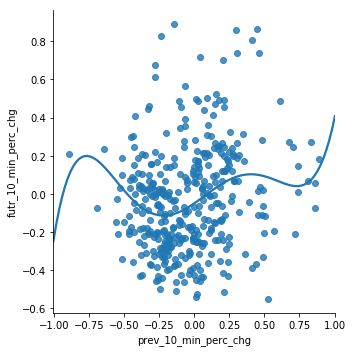

In [8]:
#sns.lmplot('prev_10_min_perc_chg', 'futr_10_min_perc_chg', data = features_df[-400:-20], fit_reg=True, order=5, ci=None)

In [ ]:
features_df

### Standardize features

In [43]:
# PCA is impacted by scale
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### PCA

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca.fit(X_train)
print(sum(pca.explained_variance_ratio_)) 

0.999987077398198


In [49]:
# Apply pca
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Model Selection

In [44]:
def print_metrics(model, y_test, X_test):
    r2 = r2_score(y_test, model.predict(X_test))
    neg_mse = mean_squared_error(y_test, model.predict(X_test))
    print(f"R2: {r2}, neg_mean_squared_error: -{neg_mse}")

### Gradient Booster

In [15]:
clf = ensemble.GradientBoostingRegressor(n_estimators=500, learning_rate=.01, max_depth=6, 
                                                         max_features=.1, min_samples_leaf=1)

clf.fit(X_train, y_train)
print_metrics(clf, y_test, X_test)

R2: 0.041671531742411894


In [ ]:
clf = ensemble.GradientBoostingRegressor(n_estimators=500, learning_rate=.02, max_depth=4, 
                                                         max_features=1, min_samples_leaf=9)
clf.fit(X_train, y_train)
print_metrics(clf, y_test, X_test)

#### GB Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01], 
              'max_depth': [4, 6],     
              'min_samples_leaf': [1, 3, 5, 9, 17], 
              'max_features': [1.0, 0.3, 0.1]} 
est = ensemble.GradientBoostingRegressor(n_estimators=2000) 
gs_cv = GridSearchCV(est, param_grid).fit(X_train, y_train) # best hyperparameter setting 
gs_cv.best_params_

### Random Forest

In [ ]:
rf = ensemble.RandomForestRegressor(n_estimators=50)

rf.fit(X_train, y_train)
print_metrics(rf, y_test, X_test)

In [ ]:
for name, importance in zip(X_train.columns, rf.feature_importances_):
    print(name, ": ", importance)

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh')

### XGBoost

In [47]:
model = xgb.XGBRegressor()

model.fit(X_train, y_train)
print_metrics(model, y_test, X_test)

ValueError: DataFrame for label cannot have multiple columns

In [ ]:
# Tuning
model = xgb.XGBRegressor(max_depth=5, n_estimators=100)

model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

train = X_train
valid = X_test
y_valid = y_test

def objective(space):
    clf = xgb.XGBRegressor(n_estimators = 100,
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])

    eval_set  = [( train, y_train), ( valid, y_valid)]

    clf.fit(train[col_train], y_train,
            eval_set=eval_set, eval_metric="auc",
            early_stopping_rounds=30)

    pred = clf.predict_proba(valid)[:,1]
    #auc = roc_auc_score(y_valid, pred)
    r2 = r2_score(y_test, model.predict(X_test))
    print("SCORE:", r2)
    return{'loss':1-r2, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform("x_max_depth", 5, 30, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

In [30]:
model.feature_importances_

array([0.01119942, 0.00830925, 0.02565029, 0.00686416, 0.00830925,
       0.00180636, 0.00541908, 0.0025289 , 0.00541908, 0.00541908,
       0.00289017, 0.0025289 , 0.        , 0.00397399, 0.00650289,
       0.00180636, 0.        , 0.        , 0.00180636, 0.        ,
       0.00397399, 0.00216763, 0.00325145, 0.00325145, 0.00216763,
       0.00072254, 0.        , 0.00072254, 0.        , 0.00578035,
       0.00361272, 0.00397399, 0.0050578 , 0.00144509, 0.00072254,
       0.00036127, 0.00216763, 0.        , 0.00433526, 0.00325145,
       0.00289017, 0.00216763, 0.00216763, 0.        , 0.00036127,
       0.00144509, 0.        , 0.00289017, 0.00469653, 0.00469653,
       0.00650289, 0.0025289 , 0.00072254, 0.00036127, 0.00180636,
       0.00036127, 0.00541908, 0.00975434, 0.00939306, 0.00614162,
       0.00180636, 0.        , 0.00036127, 0.00072254, 0.00036127,
       0.00469653, 0.00578035, 0.00614162, 0.00686416, 0.00072254,
       0.        , 0.00108382, 0.00289017, 0.        , 0.00614

### Linear Regression

In [45]:
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)
print_metrics(lm, y_test, X_test)
print_metrics(lm, y_train, X_train)

R2: -0.2903753342273536, neg_mean_squared_error: -0.003272473174747131
R2: 0.1588545927373184, neg_mean_squared_error: -0.01684568587935059


In [50]:
lm = linear_model.LinearRegression()

lm.fit(X_train_pca, y_train)
print_metrics(lm, y_test, X_test_pca)
print_metrics(lm, y_train, X_train_pca)

R2: -0.02973515669918947, neg_mean_squared_error: -0.0026114732574378263
R2: 0.054549726028090606, neg_mean_squared_error: -0.01893460772936607


In [51]:
lm = linear_model.LinearRegression()

lm.fit(X_train_std, y_train)
print_metrics(lm, y_test, X_test_std)
print_metrics(lm, y_train, X_train_std)

R2: -0.2903754423954663, neg_mean_squared_error: -0.003272473449068282
R2: 0.158854647584859, neg_mean_squared_error: -0.016845684780914538


In [63]:
lm.predict(X_test)

array([ 0.02295014, -0.00083447, -0.01416222, ..., -0.02857597,
       -0.06900365, -0.05715614])

In [68]:
lm.predict(X_test.iloc[-2].values.reshape(1, -1))

array([-0.06900365])

In [52]:
clf = linear_model.RidgeCV(alphas=(.0001,.001,.01,.1,1,10), normalize=True)
#clf = linear_model.Ridge(alpha=10, normalize=True)
clf.fit(X_train, y_train)
print_metrics(clf, y_test, X_test)

R2: -0.08123908309438588, neg_mean_squared_error: -0.0027420904608605433


In [38]:
import statsmodels.api as sm
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X)
results = model.fit()

print(results.summary())

/Users/puter/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                              OLS Regression Results                             
Dep. Variable:     futr_5_close_perc_chg   R-squared:                       0.022
Model:                               OLS   Adj. R-squared:                  0.021
Method:                    Least Squares   F-statistic:                     25.50
Date:                   Fri, 24 Aug 2018   Prob (F-statistic):               0.00
Time:                           23:39:26   Log-Likelihood:            -7.2866e+05
No. Observations:                 244270   AIC:                         1.458e+06
Df Residuals:                     244054   BIC:                         1.460e+06
Df Model:                            215                                         
Covariance Type:               nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

### Stochastic Gradient Descent Regression

In [12]:
# log data??
#y = np.log1p(y_train)
#y_ = np.log1p(y_test)

# transform and scale data
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)
X_ = scaler.transform(X_test)

In [13]:
# train
sgd = linear_model.SGDRegressor(loss='epsilon_insensitive', penalty='elasticnet', alpha=0.01, max_iter=2000)
#sgd = linear_model.SGDRegressor(penalty='l2', alpha=0.15, max_iter=2000)
#sdg = linear_model.SGDRegressor(penalty='elasticnet', loss='epsilon_insensitive', alpha=0.15, max_iter=2000)

sgd.fit(X, y_train)
print_metrics(sgd, y_test, X_)

R2: 0.013607450268719234, neg_mean_squared_error: -0.06305004975656273


In [22]:
sgd.predict(X_)

array([-0.01086168,  0.03267978,  0.03918176, ..., -0.00410809,
        0.00513214,  0.00354583])

In [9]:
# Grid search
# Do I need a custom grid search?? The scoring will be otpimizing parameters on test data that has the answers...
from sklearn.model_selection import GridSearchCV 
param_grid = {'alpha': [0.15,0.1,0.01,0.0001],#[0.2,0.15,0.1,0.01,0.001,0.0001,0.00001], 
              'max_iter': [200,600,1200,6000],#[50,200,600,1200,2000,6000,12000],     
              'loss': ['squared_loss','epsilon_insensitive'],#['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'], 
              'penalty': ['l2','elasticnet']}#['l2','l1','elasticnet']} 
est = linear_model.SGDRegressor() 
sgd_cv = GridSearchCV(est, param_grid).fit(X, y_train) # best hyperparameter setting 
sgd_cv.best_params_

{'alpha': 0.01,
 'loss': 'epsilon_insensitive',
 'max_iter': 1200,
 'penalty': 'elasticnet'}

### Support Vector Machine (RBF Kernel)

In [ ]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

svr_rbf.fit(X_train, y_train)
print_metrics(svr_rbf, y_test, X_test)

### Polynomial Regression (with Ridge Regularization)

In [ ]:
%%time

poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X_train)
X_ = poly.fit_transform(X_test)
#clf = linear_model.LinearRegression(normalize=True)
clf = linear_model.RidgeCV(alphas=(.0001,.001,.01,.1,1,10), normalize=True)
#clf = linear_model.Ridge(alpha=10, normalize=True)
clf.fit(X, y_train)
print(r2_score(y_test, clf.predict(X_)))

# Validate Scoring Features

For this to work, you must adjust the scoring library to return more than 970 minuts worth of data

In [5]:
import market_maker_scoring

mm_scoring = market_maker_scoring.CobinhoodScoring()
# Set scoring data and retrieve the most recent minutes features
mm_scoring.set_scoring_data(in_parallel=False)
recent_df = mm_scoring.scoring_features_df.sort_values('open_time')
recent_df

2018-09-07 07:05:08 Chriss-MacBook-Pro.local cobinhood-api[17179] DEBUG cobinhood_api.http.market fetch "get_trading_pairs"
2018-09-07 07:05:09 Chriss-MacBook-Pro.local cobinhood-api[17179] DEBUG cobinhood_api.http.market fetch "get_trading_pairs"
2018-09-07 07:05:09 Chriss-MacBook-Pro.local cobinhood-api[17179] DEBUG cobinhood_api.http.chart fetch "get_candles"
2018-09-07 07:05:11 Chriss-MacBook-Pro.local cobinhood-api[17179] DEBUG cobinhood_api.http.market fetch "get_trading_pairs"
2018-09-07 07:05:11 Chriss-MacBook-Pro.local cobinhood-api[17179] DEBUG cobinhood_api.http.chart fetch "get_candles"
2018-09-07 07:05:13 Chriss-MacBook-Pro.local cobinhood-api[17179] DEBUG cobinhood_api.http.market fetch "get_trading_pairs"
2018-09-07 07:05:13 Chriss-MacBook-Pro.local cobinhood-api[17179] DEBUG cobinhood_api.http.chart fetch "get_candles"


btcusdt_close  btcusdt_high  btcusdt_low  btcusdt_open timeframe_x  \
0            6963.6        6963.6       6963.6        6963.6          1m   
1            6965.0        6965.0       6965.0        6965.0          1m   
2            6979.5        6982.2       6970.1        6970.1          1m   
3            6985.4        6985.4       6985.4        6985.4          1m   
4            6987.2        6987.2       6987.2        6987.2          1m   
5            6988.7        6989.8       6988.7        6989.8          1m   
6            6977.4        6987.2       6977.4        6987.2          1m   
7            6977.4        6977.4       6977.4        6977.4          1m   
8            6977.4        6977.4       6977.4        6977.4          1m   
9            6992.3        6993.9       6992.3        6993.9          1m   
10           7002.1        7002.1       7001.4        7001.4          1m   
11           7022.2        7022.2       7016.4        7016.4          1m   
12           7012.9        7012.9       7012.9        7012.9          1m   
13           7025.2        7025.2       7025.2        7025.2          1m   
14           7018.9        7023.6       7018.9        7023.6          1m   
15           7018.5        7018.5       7018.5        7018.5          1m   
16           7018.5        7018.5       7018.5        7018.5          1m   
17           7008.9        7008.9       6986.9        6986.9          1m   
18           7008.9        7008.9       7008.9        7008.9          1m   
19           7008.9        7008.9       7008.9        7008.9          1m   
20           7008.9        7008.9       7008.9        7008.9          1m   
21           7003.3        7003.3       7003.3        7003.3          1m   
22           7003.3        7003.3       7003.3        7003.3          1m   
23           7006.8        7006.8       7006.8        7006.8          1m   
24           7006.8        7016.2       7006.8        7016.2          1m   
25           7015.8        7015.8       7006.8        7006.8          1m   
26           7013.3        7014.3       7007.1        7007.1          1m   
27           7006.8        7006.8       7006.8        7006.8          1m   
28           7006.8        7006.8       7006.8        7006.8          1m   
29           7001.5        7009.1       7001.5        7009.1          1m   
30           7002.3        7002.3       7000.4        7000.4          1m   
31           7000.4        7000.4       7000.4        7000.4          1m   
32           7000.4        7000.4       7000.4        7000.4          1m   
33           7000.4        7000.4       7000.4        7000.4          1m   
34           6999.8        6999.8       6999.8        6999.8          1m   
35           6999.8        6999.8       6999.8        6999.8          1m   
36           7006.8        7006.8       6999.0        7006.1          1m   
37           6993.0        6999.0       6993.0        6999.0          1m   
38           6993.0        6993.0       6993.0        6993.0          1m   
39           6986.0        6996.3       6986.0        6990.1          1m   
40           6964.5        6964.5       6963.9        6963.9          1m   
41           6966.2        6966.2       6966.2        6966.2          1m   
42           6966.2        6966.2       6966.2        6966.2          1m   
43           6978.1        6978.1       6976.0        6976.0          1m   
44           6974.6        6974.6       6974.6        6974.6          1m   
45           6972.0        6972.0       6972.0        6972.0          1m   
46           6972.0        6972.0       6972.0        6972.0          1m   
47           6972.0        6972.0       6972.0        6972.0          1m   
48           6965.1        6972.0       6965.1        6972.0          1m   
49           6965.1        6965.1       6965.1        6965.1          1m   
...             ...           ...          ...           ...         ...   
2840         6398.4        6398.4       6398.4        

In [7]:
# Check time diff
import time
latest_timestamp = recent_df.iloc[-1:]['close_timestamp'].item() / 1000
print(f"Last timestamp in scoring data: {latest_timestamp} compared to current: {time.time()} with {time.time() - latest_timestamp}")

Last timestamp in scoring data: 1536318300.0 compared to current: 1536318364.212915 with 64.21291708946228


In [109]:
X_scoring = recent_df[mm_scoring.feature_column_list]
X_scoring.iloc[-2]

trade_day_of_week                              1.000000
trade_hour                                    12.000000
btcusdt_close                               7255.100000
btcusdt_volume                                 0.000000
prev_1_btcusdt_close_perc_chg                  0.000000
prev_1_btcusdt_close_rate_chg                  0.000000
prev_1_btcusdt_volume_perc_chg                 0.000000
prev_1_btcusdt_volume_direction                0.000000
prev_5_btcusdt_close_perc_chg                 -0.059234
prev_5_btcusdt_close_rate_chg                  0.059234
prev_5_btcusdt_volume_perc_chg                 0.000000
prev_5_btcusdt_volume_direction               -0.000000
ethusdt_close                                288.620000
ethusdt_volume                                 0.000000
avg_1_ethusdt_close_interaction                0.000000
avg_5_ethusdt_close_interaction               -0.000011
avg_10_ethusdt_close_interaction               0.000021
avg_20_ethusdt_close_interaction               0

In [8]:
scoring_features = recent_df[feature_col]
scoring_features['btcusdt_trade_minute'] = recent_df['close_timestamp']//1000//60
scoring_features

trade_day_of_week  trade_hour  btcusdt_close  btcusdt_volume  \
0                     3          10         6963.6        0.000000   
1                     3          10         6965.0        0.135844   
2                     3          10         6979.5        0.684224   
3                     3          10         6985.4        0.084723   
4                     3          11         6987.2        0.013568   
5                     3          11         6988.7        0.594330   
6                     3          11         6977.4        0.068864   
7                     3          11         6977.4        0.000000   
8                     3          11         6977.4        0.000000   
9                     3          11         6992.3        0.050000   
10                    3          11         7002.1        0.299698   
11                    3          11         7022.2        0.290348   
12                    3          11         7012.9        0.257664   
13                    3          11         7025.2        0.096139   
14                    3          11         7018.9        0.030989   
15                    3          11         7018.5        0.030989   
16                    3          11         7018.5        0.000000   
17                    3          11         7008.9        0.487371   
18                    3          11         7008.9        0.000000   
19                    3          11         7008.9        0.000000   
20                    3          11         7008.9        0.000000   
21                    3          11         7003.3        0.060568   
22                    3          11         7003.3        0.000000   
23                    3          11         7006.8        0.047250   
24                    3          11         7006.8        0.052066   
25                    3          11         7015.8        0.205069   
26                    3          11         7013.3        0.929946   
27                    3          11         7006.8        0.022011   
28                    3          11         7006.8        0.022011   
29                    3          11         7001.5        0.159774   
30                    3          11         7002.3        0.286644   
31                    3          11         7000.4        0.396436   
32                    3          11         7000.4        0.000000   
33                    3          11         7000.4        0.000000   
34                    3          11         6999.8        0.081650   
35                    3          11         6999.8        0.000000   
36                    3          11         7006.8        0.245065   
37                    3          11         6993.0        0.034902   
38                    3          11         6993.0        0.000000   
39                    3          11         6986.0        0.186454   
40                    3          11         6964.5        0.075671   
41                    3          11         6966.2        0.009000   
42                    3          11         6966.2        0.000000   
43                    3          11         6978.1        0.379420   
44                    3          11         6974.6        0.011802   
45                    3          11         6972.0        0.014197   
46                    3          11         6972.0        0.000000   
47                    3          11         6972.0        0.000000   
48                    3          11         6965.1        0.120648   
49                    3          11         6965.1        0.000000   
...                 ...         ...            ...             ...   
2840                  5          10         6398.4        0.113438   
2841                  5          10         6405.5        0.372367   
2842                  5          10         6405.5        0.000000   
2843                  5          10         6396.2        0.556049   
2844                  5          10         6381.2        0.076902   
2845            

In [9]:
train_features = features_df[features_df['btcusdt_trade_minute'] >= scoring_features.iloc[0]['btcusdt_trade_minute'].item()]
training_features = train_features[feature_col]
training_features['btcusdt_trade_minute'] = train_features['btcusdt_trade_minute']
training_features

trade_day_of_week  trade_hour  btcusdt_close  btcusdt_volume  \
137456                  3          10         6963.6        0.000000   
137457                  3          10         6965.0        0.135844   
137458                  3          10         6979.5        0.684224   
137459                  3          10         6985.4        0.084723   
137460                  3          11         6987.2        0.013568   
137461                  3          11         6988.7        0.594330   
137462                  3          11         6977.4        0.068864   
137463                  3          11         6977.4        0.000000   
137464                  3          11         6977.4        0.000000   
137465                  3          11         6992.3        0.050000   
137466                  3          11         7002.1        0.299698   
137467                  3          11         7022.2        0.290348   
137468                  3          11         7012.9        0.257664   
137469                  3          11         7025.2        0.096139   
137470                  3          11         7018.9        0.030989   
137471                  3          11         7018.5        0.030989   
137472                  3          11         7018.5        0.000000   
137473                  3          11         7008.9        0.487371   
137474                  3          11         7008.9        0.000000   
137475                  3          11         7008.9        0.000000   
137476                  3          11         7008.9        0.000000   
137477                  3          11         7003.3        0.060568   
137478                  3          11         7003.3        0.000000   
137479                  3          11         7006.8        0.047250   
137480                  3          11         7006.8        0.052066   
137481                  3          11         7015.8        0.205069   
137482                  3          11         7013.3        0.929946   
137483                  3          11         7006.8        0.022011   
137484                  3          11         7006.8        0.022011   
137485                  3          11         7001.5        0.159774   
137486                  3          11         7002.3        0.286644   
137487                  3          11         7000.4        0.396436   
137488                  3          11         7000.4        0.000000   
137489                  3          11         7000.4        0.000000   
137490                  3          11         6999.8        0.081650   
137491                  3          11         6999.8        0.000000   
137492                  3          11         7006.8        0.245065   
137493                  3          11         6993.0        0.034902   
137494                  3          11         6993.0        0.000000   
137495                  3          11         6986.0        0.186454   
137496                  3          11         6964.5        0.075671   
137497                  3          11         6966.2        0.009000   
137498                  3          11         6966.2        0.000000   
137499                  3          11         6978.1        0.379420   
137500                  3          11         6974.6        0.011802   
137501                  3          11         6972.0        0.014197   
137502                  3          11         6972.0        0.000000   
137503                  3          11         6972.0        0.000000   
137504                  3          11         6965.1        0.120648   
137505                  3          11         6965.1        0.000000   
...                   ...         ...            ...             ...   
139630                  4          23         6496.3        0.000000   
139631                  4          23         6494.2        0.329787   
139632                  4          23         6493.2        0.511553   
139633                  4          23         64

In [10]:
merged = pd.merge(scoring_features, training_features, on=['btcusdt_trade_minute'], how='inner')

In [11]:
# Interleave columns
my_cols_x = [x+'_x' for x in feature_col]
my_cols_y = [x+'_y' for x in feature_col]

from itertools import chain
interleaved_cols = list(chain.from_iterable(zip(my_cols_y, my_cols_x)))
interleaved_cols = ['btcusdt_trade_minute'] + interleaved_cols

In [12]:
merged[interleaved_cols]

btcusdt_trade_minute  trade_day_of_week_y  trade_day_of_week_x  \
0                 25602416                    3                    3   
1                 25602417                    3                    3   
2                 25602418                    3                    3   
3                 25602419                    3                    3   
4                 25602420                    3                    3   
5                 25602421                    3                    3   
6                 25602422                    3                    3   
7                 25602423                    3                    3   
8                 25602424                    3                    3   
9                 25602425                    3                    3   
10                25602426                    3                    3   
11                25602427                    3                    3   
12                25602428                    3                    3   
13                25602429                    3                    3   
14                25602430                    3                    3   
15                25602431                    3                    3   
16                25602432                    3                    3   
17                25602433                    3                    3   
18                25602434                    3                    3   
19                25602435                    3                    3   
20                25602436                    3                    3   
21                25602437                    3                    3   
22                25602438                    3                    3   
23                25602439                    3                    3   
24                25602440                    3                    3   
25                25602441                    3                    3   
26                25602442                    3                    3   
27                25602443                    3                    3   
28                25602444                    3                    3   
29                25602445                    3                    3   
30                25602446                    3                    3   
31                25602447                    3                    3   
32                25602448                    3                    3   
33                25602449                    3                    3   
34                25602450                    3                    3   
35                25602451                    3                    3   
36                25602452                    3                    3   
37                25602453                    3                    3   
38                25602454                    3                    3   
39                25602455                    3                    3   
40                25602456                    3                    3   
41                25602457                    3                    3   
42                25602458                    3                    3   
43                25602459                    3                    3   
44                25602460                    3                    3   
45                25602461                    3                    3   
46                25602462                    3                    3   
47                25602463                    3                    3   
48                25602464                    3                    3   
49                25602465                    3                    3   
...                    ...                  ...                  ...   
2174              25604590                    4                    4   
2175              25604591                    4                    4   
2176              25604592                    4                    4   
2177              25604593                    

In [13]:
merged[interleaved_cols].to_csv('test_interleaved_train_test.csv')

# Simulate Return on Rolling Historical Data

In [ ]:
def simulate_return(model, df, feature_cols, target_col, start_days=1, training_mins=None, test_mins=1440):
    start_ix = 1440 * start_days
    results_df_list = []
    intervals = df[start_ix:].trade_date.nunique() * 1440 / test_mins
    for day in range(int(intervals)):
        end_train_ix = (day * test_mins) + start_ix
        end_test_ix = ((day * test_mins) + test_mins) + start_ix
        if training_mins:
            start_train_ix = end_train_ix - training_mins
            start_train_ix = 0 if start_train_ix < 0 else start_train_ix
            train_df = df.iloc[start_train_ix:end_train_ix,:]
        else:
            train_df = df.iloc[:end_train_ix,:]
        test_df = df.iloc[end_train_ix:end_test_ix,:]
        if test_df.empty:
            break
        if not pd.merge(train_df, test_df, on='trade_minute', how='inner').empty:
            print("The test and training sets overlap!!")
        X = train_df.loc[:,feature_cols]
        y = train_df.loc[:,target_col]
        X_sim = test_df.loc[:,feature_cols]
        
        if model == 'polynomial':
            poly = PolynomialFeatures(degree=3)
            X_ = poly.fit_transform(X)
            predict_ = poly.fit_transform(X_sim)
            clf = linear_model.RidgeCV(alphas=(.00001,.0001,.001,.01,.1,1,10), normalize=True)
            #clf = linear_model.Ridge(alpha=.01, normalize=True)
            #clf = linear_model.LinearRegression()
            clf.fit(X_, y)
            y_sim = clf.predict(predict_)
        else:
            model.fit(X, y)
            X_sim = test_df.loc[:,feature_cols]
            y_sim = model.predict(X_sim)
        y_act = test_df.loc[:,target_col]
        # 
        test_df.loc[:,'return'] = test_df[target_col] - .1  # how much for fees?
        test_df.loc[:,'predicted'] = y_sim
        results_df_list.append(test_df)
        
    results_df = pd.concat(results_df_list)
    
    # Identify best cut off
    optimal_buy_threshold = None
    best_return = 0
    num_trades = 0
    for thresh in list(np.arange(-4.0, 4.0, 0.1)):
        return_df = results_df.loc[results_df['predicted'] > thresh]
        if (return_df['return'].sum() > best_return) or (optimal_buy_threshold == None):
            optimal_buy_threshold = thresh
            best_return, num_trades = return_df['return'].sum(), len(return_df.index)
            
    # print/return
    results_df.loc[results_df['predicted'] >= optimal_buy_threshold, 'buy'] = 1 # reset buy threshold with optimum
    print(f"""Best Return at {optimal_buy_threshold}: {best_return}%
    Target: {target_col}; start_days: {start_days}; training_mins: {training_mins}; test_mins: {test_mins}
    Number of intervals simulating {intervals}
    Trades: {num_trades}""")
    daily_trades = results_df.loc[results_df['buy'] == 1].groupby('trade_date').agg({'return':'sum','trade_minute':'count'})
    return results_df, daily_trades


In [ ]:
X_train

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
import seaborn as sns
#plt_df = pd.concat([X_train, y_train], axis=0)
sns.lmplot('prev_10_min_perc_chg', 'futr_10_min_perc_chg', data = features_df[-500:-20], fit_reg=True, order=6, ci=None)

### Simulate Polynomial Regression

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=110, training_mins=360, test_mins=5)

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg',#'prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'

results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=110, training_mins=120, test_mins=5)

In [ ]:
# Specific time period Feb 10th to 28th
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg',#'prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'
data = features_df.loc[(features_df['trade_date'] > '2018-02-10') & (features_df['trade_date'] < '2018-02-27')]
results_df, daily_trades = simulate_return('polynomial', data, feature_cols, target_col, training_mins=120, test_mins=5)

In [ ]:
daily_trades

In [ ]:
results_df[results_df['predicted'] > .4]['return'].sum()
results_df.loc[results_df['predicted'] > .4].groupby('trade_date').agg({'return':'sum','trade_minute':'count'})

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

thresholds = list(range(60, 60*24, 120))
optimal = {}
for threshold in thresholds:
    results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=60, training_mins=threshold, test_mins=10)

In [ ]:
# Find best Feature set, training length, and testing length
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

thresholds = list(range(60, 60*24, 120)) # 1 hour - 24 hours
thresholds = list(range(60*24, 60*24*12, 60*24)) # 1 day - 12 days
optimal = {}
for threshold in thresholds:
    results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=60, training_mins=threshold, test_mins=10)

### Simulate Gradient Booster

In [ ]:
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'
model = ensemble.GradientBoostingRegressor(n_estimators=2000, learning_rate=.02, max_depth=4, 
                                                         max_features=1, min_samples_leaf=9)
results_df, daily_trades = simulate_return(model, features_df, feature_cols, target_col, start_days=110)

In [ ]:
daily_trades

# Experiment with Classifiers

In [ ]:
# Where to put buy label threshold?
features_df.loc[(features_df['futr_5_min_perc_chg'] > 0) & (features_df['futr_5_min_perc_chg'] < 2),'futr_5_min_perc_chg'].hist()

In [ ]:
features_df['buy'] = 0
features_df.loc[features_df['futr_5_min_perc_chg'] > 1,'buy'] = 1
target_col = 'buy'

train_df = features_df.iloc[5000:,:]
test_df = features_df.iloc[0:5000,:]

# Upsample 'buy' class
df_majority = train_df[features_df.buy==0]
df_minority = train_df[features_df.buy==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority.index),    # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
X_train, X_test, y_train, y_test = df_upsampled[feature_cols], test_df[feature_cols], df_upsampled[target_col], test_df[target_col] 

In [ ]:
train_df['buy'].value_counts()

In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators=50)

rfc.fit(X_train, y_train)
print(classification_report(y_test, rfc.predict(X_test)))

In [ ]:
lgr = LogisticRegression()

lgr.fit(X_train, y_train)
print(classification_report(y_test, lgr.predict(X_test)))

In [ ]:
test_df['buy_pred'] = lgr.predict(X_test)
test_df[test_df['buy_pred'] == 1]['futr_5_min_perc_chg'].sum()

In [ ]:
test_df['futr_5_min_perc_chg'].sum()

### Simulate Classifer

In [ ]:
start_date = 1440*30
training_data_length = 1440*0 

feature_cols = ['avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'prev_5_min_perc_chg']
target_col = 'buy'

total_return = []
trades = []
results_df_list = []

print(f"Number of days simulating {features_df[start_date:].trade_date.nunique()}")
for day in range(features_df.trade_date.nunique()):
    # Reset
    end_train_period = ((day + 2) * 1440) + start_date
    start_train_period = end_train_period - training_data_length
    end_test_period = ((day + 3) * 1440) + start_date
    train_df = features_df.iloc[:end_train_period,:]
    test_df = features_df.iloc[end_train_period:end_test_period,:]
    
    # Upsample 'buy' class
    df_majority = train_df[features_df.buy==0]
    df_minority = train_df[features_df.buy==1]
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority.index),    # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    if test_df.empty:
        break
    X = df_upsampled[feature_cols]
    y = df_upsampled[target_col]
    #
    model = LogisticRegression()
    model.fit(X, y)
    #
    X_sim = test_df[feature_cols]
    y_act = test_df['futr_5_min_perc_chg']
    y_sim = model.predict(X_sim)
    #
    test_df['return'] = test_df['futr_5_min_perc_chg'] - .1
    test_df['predicted'] = y_sim
    results_df_list.append(test_df)
    # print
    sim_buy_df = test_df.loc[test_df['predicted'] == 1]
    total_return.append(sim_buy_df['return'].sum())
    trades = trades + list(sim_buy_df['return'])
print(sum(total_return))
print(len(trades))
results_df = pd.concat(results_df_list)

In [ ]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=50)

gbc.fit(X_train, y_train)
print(classification_report(y_test, gbc.predict(X_test)))

In [ ]:
sv = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)

sv.fit(X_train, y_train)
print(classification_report(y_test, sv.predict(X_test)))

## Simulate Predictions on Custom Time Period

In [ ]:
train_df = features_df.iloc[5000:,:]
test_df = features_df.iloc[0:5000,:]

X = train_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
y = train_df['futr_5_min_perc_chg']

model = linear_model.LinearRegression()
model.fit(X, y)

In [ ]:
X_sim = test_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
y_act = test_df['futr_5_min_perc_chg']
y_sim = model.predict(X_sim)

In [ ]:
sim_df = pd.DataFrame(data={'actual':y_act, 'predicted':y_sim})
sim_df.loc[sim_df['predicted'] > .5, 'buy'] = 1
sim_df.head(20)

In [ ]:
sim_buy_df = sim_df.loc[sim_df['buy'] == 1]
sim_buy_df['return'] = sim_buy_df['actual'] - .1 # 50 cents is roughly the cost to trade 1 $500 etherium
sim_buy_df

In [ ]:
sim_buy_df['return'].sum()

## Simulate Predictions Across All Days

In [ ]:
train_df = features_df.iloc[1440:,:]
test_df = features_df.iloc[0:1440,:]

total_return = []
print(f"Number of days simulating {features_df.trade_date.nunique()}")
for day in range(features_df.trade_date.nunique()):
    X = train_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
    y = train_df['futr_5_min_perc_chg']
    #
    model = linear_model.LinearRegression()
    model.fit(X, y)
    #
    X_sim = test_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
    y_act = test_df['futr_5_min_perc_chg']
    y_sim = model.predict(X_sim)
    #
    sim_df = pd.DataFrame(data={'actual':y_act, 'predicted':y_sim})
    sim_df.loc[sim_df['predicted'] > .5, 'buy'] = 1
    #
    sim_buy_df = sim_df.loc[sim_df['buy'] == 1]
    sim_buy_df['return'] = sim_buy_df['actual'] - .1 
    total_return.append(sim_buy_df['return'].sum())
    # Reset
    train_df_1 = features_df.iloc[:(day+2)*1440,:]
    train_df_2 = features_df.iloc[(day+3)*1440:,:]
    train_df = pd.concat([train_df_1, train_df_2])
    test_df = features_df.iloc[(day+2)*1440:(day+3)*1440,:]
    if test_df.empty:
        break

In [ ]:
total_return

In [ ]:
sum(total_return)

In [ ]:
pd.merge(train_df, test_df, on=['trade_minute'],how='inner')

## Validation

In [ ]:
features_df.loc[start_date:,'futr_5_min_perc_chg'].sum()

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(sim_buy_df[['predicted','return']])

## Market Buy discrepency

In [18]:
import market_maker_scoring
mm_scoring = market_maker_scoring.MarketMakerScoring()

sql="""select * 
from the_logic.scoring_results
where is_trade = true
order by trade_datetime desc"""

trade_df = mm_scoring.pandas_read_postgres(sql)
trade_df

trade_datetime  trade_minute target_coin  trade_duration  \
0   2018-08-06 07:23:44      25559002     ethusdt              10   
1   2018-08-06 01:45:29      25558664     ethusdt              10   
2   2018-08-05 19:13:19      25558272     ethusdt              25   
3   2018-08-05 09:55:33      25557714     ethusdt              25   
4   2018-08-05 01:03:19      25557182     ethusdt              25   
5   2018-08-05 00:49:40      25557168     ethusdt              10   
6   2018-08-04 23:59:12      25557118     ethusdt              25   
7   2018-08-04 15:36:10      25556615     ethusdt              25   
8   2018-08-03 22:47:42      25555606     ethusdt              25   
9   2018-08-01 22:00:30      25552679     ethusdt              25   
10  2018-07-31 23:24:23      25551323     ethusdt              25   
11  2018-07-31 16:10:26      25550889     ethusdt              25   
12  2018-07-30 21:02:17      25549741     ethusdt              25   
13  2018-07-30 14:59:30      25549378     ethusdt               9   
14  2018-07-29 23:23:33      25548442     ethusdt              25   
15  2018-07-29 17:13:46      25548072     ethusdt              25   
16  2018-07-20 02:02:37      25534201     ethusdt              25   
17  2018-07-19 22:39:27      25533998     ethusdt              25   
18  2018-07-17 18:03:45      25530842     ethusdt              25   
19  2018-07-17 17:38:05      25530817     ethusdt              25   
20  2018-07-15 08:53:42      25527412     ethusdt              25   
21  2018-07-14 20:41:47      25526680     ethusdt              25   
22  2018-07-13 23:56:38      25525435     ethusdt              25   
23  2018-07-13 20:03:38      25525202     ethusdt              25   
24  2018-07-13 18:21:30      25525100     ethusdt              25   
25  2018-07-13 04:02:19      25524241     ethusdt              25   
26  2018-07-11 10:10:08      25521729     ethusdt              10   
27  2018-07-11 08:42:33      25521641     ethusdt               5   
28  2018-07-11 07:46:31      25521585     ethusdt              10   
29  2018-07-11 07:03:19      25521542     ethusdt               8   
30  2018-07-11 06:36:13      25521515     ethusdt              10   
31  2018-07-11 06:17:12      25521496     ethusdt              10   
32  2018-07-11 05:54:38      25521473     ethusdt              10   
33  2018-07-11 03:59:14      25521358     ethusdt              10   
34  2018-07-11 00:40:25      25521159     ethusdt              10   
35  2018-07-11 00:34:39      25521153     ethusdt               5   
36  2018-07-11 00:20:44      25521139     ethusdt               7   
37  2018-07-11 00:10:42      25521129     ethusdt              10   
38  2018-07-10 23:25:37      25521084     ethusdt               5   
39  2018-07-10 19:12:10      25520831     ethusdt              10   
40  2018-07-10 18:25:44      25520784     ethusdt               7   
41  2018-07-10 17:41:17      25520740     ethusdt               6   
42  2018-07-10 17:00:28      25520699     ethusdt               6   
43  2018-07-10 15:38:36      25520617     ethusdt               5   
44  2018-07-10 14:51:11      25520570     ethusdt              10   
45  2018-07-10 14:39:06      25520558     ethusdt               8   
46  2018-07-10 13:38:32      25520497     ethusdt              10   
47  2018-07-10 13:25:08      25520484     ethusdt              10   
48  2018-07-10 13:04:32      25520463     ethusdt              10   
49  2018-07-10 12:42:38      25520441     ethusdt              10   
..                  ...           ...         ...             ...   
54  2018-07-10 10:27:08      25520306     ethusdt              10   
55  2018-07-10 10:15:15      25520294     ethusdt              10   
56  2018-07-10 10:01:26      25520280     ethusdt              10   
57  2018-07-10 09:51:32      25520270     ethusdt               9   
58  2018-07-10 09:38:49      25520257     ethusdt               5   
59  2018-07-10 09:29:11      25520248     ethusdt               7   
60  201

In [19]:
mm_scoring.get_trade_qty(target_coin=mm_scoring.target_coin.upper())

0.08673857520171405

In [84]:
feature_minutes_list = [5]
t_df, fc, target_col = features(feature_minutes_list, trade_window_list=[1,2,5,6,7])
t_df.head(20)

Coin feature configuration: {'ethusdt': 'target', 'btcusdt': 'alt', 'trxeth': 'through'}


/Users/puter/OneDrive/Projects/logic_by_loidsig/src/lib/market_maker_training.py:45: DtypeWarning: Columns (44,45,46,47,48,53,54,55,56,57,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  features_df = athena.pandas_read_athena(training_data_sql)


(271699, 72)
(271694, 72)


ethusdt_trade_datetime ethusdt_trade_date  ethusdt_trade_minute  \
5   2018-01-01 00:05:59.000         2018-01-01              25246085   
6   2018-01-01 00:06:59.000         2018-01-01              25246086   
7   2018-01-01 00:07:59.000         2018-01-01              25246087   
8   2018-01-01 00:08:59.000         2018-01-01              25246088   
9   2018-01-01 00:09:59.000         2018-01-01              25246089   
10  2018-01-01 00:10:59.000         2018-01-01              25246090   
11  2018-01-01 00:11:59.000         2018-01-01              25246091   
12  2018-01-01 00:12:59.000         2018-01-01              25246092   
13  2018-01-01 00:13:59.000         2018-01-01              25246093   
14  2018-01-01 00:14:59.000         2018-01-01              25246094   
15  2018-01-01 00:15:59.000         2018-01-01              25246095   
16  2018-01-01 00:16:59.000         2018-01-01              25246096   
17  2018-01-01 00:17:59.000         2018-01-01              25246097   
18  2018-01-01 00:18:59.000         2018-01-01              25246098   
19  2018-01-01 00:19:59.000         2018-01-01              25246099   
20  2018-01-01 00:20:59.000         2018-01-01              25246100   
21  2018-01-01 00:21:59.000         2018-01-01              25246101   
22  2018-01-01 00:22:59.000         2018-01-01              25246102   
23  2018-01-01 00:23:59.000         2018-01-01              25246103   
24  2018-01-01 00:24:59.000         2018-01-01              25246104   

    trade_day_of_week  trade_hour  ethusdt_open  ethusdt_high  ethusdt_low  \
5                   1           0        728.50        729.80       727.11   
6                   1           0        727.99        727.99       725.00   
7                   1           0        727.31        727.42       725.00   
8                   1           0        725.09        727.17       724.43   
9                   1           0        727.08        727.25       725.16   
10                  1           0        727.26        727.31       725.00   
11                  1           0        725.07        727.01       722.91   
12                  1           0        726.18        726.57       723.70   
13                  1           0        725.06        726.58       725.01   
14                  1           0        726.55        727.31       725.01   
15                  1           0        727.22        728.44       725.01   
16                  1           0        727.44        728.37       725.32   
17                  1           0        728.37        728.37       727.00   
18                  1           0        727.00        727.00       723.72   
19                  1           0        725.12        725.20       723.00   
20                  1           0        724.99        725.00       723.24   
21                  1           0        724.98        724.98       723.00   
22                  1           0        724.82        724.83       723.04   
23                  1           0        724.29        724.50       723.00   
24                  1           0        723.93        723.93       722.91   

    ethusdt_close  ethusdt_volume  ethusdt_quote_asset_volume  \
5          727.11        12.01907                 8755.309915   
6          727.60        20.87418                15146.878732   
7          725.01        33.23205                24105.332157   
8          727.09        24.53052                17803.658721   
9          727.25        44.26183                32140.691661   
10         725.02        21.41044                15527.491154   
11         725.06        47.25949                34283.271158   
12         725.06        35.04766                25426.374449   
13         726.56        17.59799                12773.006725   
14         727.31        31.12629                22624.826761   
15         727.44        37.82569                27509.493120   
16         728.37        18.69843                13600.744673   
17      

In [85]:
target_col

['futr_1_open_perc_chg',
 'futr_2_open_perc_chg',
 'futr_5_open_perc_chg',
 'futr_6_open_perc_chg',
 'futr_7_open_perc_chg']

In [88]:
t_df['trade_minute'] = t_df['ethusdt_trade_minute']
trade_features = ['trade_datetime','trade_minute','predicted_return','trade_duration','buy_price','sell_price']
t_df['open_7'] = t_df['ethusdt_open'] * (1 + (t_df['futr_7_open_perc_chg'] / 100))
t_df['open_6'] = t_df['ethusdt_open'] * (1 + (t_df['futr_6_open_perc_chg'] / 100))
t_df['open_5'] = t_df['ethusdt_open'] * (1 + (t_df['futr_5_open_perc_chg'] / 100))
t_df['open_2'] = t_df['ethusdt_open'] * (1 + (t_df['futr_2_open_perc_chg'] / 100))
t_df['open_1'] = t_df['ethusdt_open'] * (1 + (t_df['futr_1_open_perc_chg'] / 100))
train_features = ['ethusdt_trade_datetime','trade_minute','ethusdt_open','ethusdt_close','open_1','open_2','open_5','open_6','open_7',
                  'futr_1_open_perc_chg','futr_2_open_perc_chg','futr_5_open_perc_chg','futr_6_open_perc_chg','futr_7_open_perc_chg']

pd.merge(trade_df[trade_features], t_df[train_features], on='trade_minute', how='inner')

trade_datetime  trade_minute  predicted_return  trade_duration  \
0  2018-07-10 23:25:37      25521084          0.243805               5   
1  2018-07-10 19:12:10      25520831          0.230944              10   
2  2018-07-10 18:25:44      25520784          0.244237               7   
3  2018-07-10 17:41:17      25520740          0.256922               6   
4  2018-07-10 17:00:28      25520699          0.208198               6   
5  2018-07-10 15:38:36      25520617          0.326445               5   
6  2018-07-10 14:51:11      25520570          0.540706              10   
7  2018-07-10 14:39:06      25520558          0.338875               8   
8  2018-07-10 13:38:32      25520497          0.220851              10   
9  2018-07-10 13:25:08      25520484          0.319396              10   
10 2018-07-10 13:04:32      25520463          0.205712              10   
11 2018-07-10 12:42:38      25520441          0.302462              10   
12 2018-07-10 12:18:17      25520417          0.226079              10   
13 2018-07-10 12:05:11      25520404          0.320581               7   
14 2018-07-10 11:42:23      25520381          0.229228              10   
15 2018-07-10 10:53:39      25520332          0.201943               5   
16 2018-07-10 10:27:08      25520306          0.309204              10   
17 2018-07-10 10:15:15      25520294          0.418821              10   
18 2018-07-10 10:01:26      25520280          0.375865              10   
19 2018-07-10 09:51:32      25520270          0.257232               9   
20 2018-07-10 09:38:49      25520257          0.212344               5   
21 2018-07-10 09:29:11      25520248          0.234677               7   
22 2018-07-10 08:54:22      25520213          0.352516               6   
23 2018-07-10 08:02:31      25520161          0.583099              10   
24 2018-07-10 06:32:26      25520071          0.226306               6   
25 2018-07-10 05:40:05      25520019          0.246808              10   
26 2018-07-10 04:41:47      25519960          0.241505              10   
27 2018-07-10 04:15:33      25519934          0.293398               6   
28 2018-07-10 03:56:29      25519915          0.274489               7   
29 2018-07-10 03:36:40      25519895          0.211203              10   
30 2018-07-10 03:14:12      25519873          0.311608               6   
31 2018-07-10 03:03:43      25519862          0.268835               7   
32 2018-07-10 02:53:49      25519852          0.233644              10   
33 2018-07-10 02:13:39      25519812          0.275804               5   
34 2018-07-10 01:10:42      25519749          0.202653               6   
35 2018-07-10 00:37:45      25519716          0.214812               6   
36 2018-07-10 00:16:34      25519695          0.214762               5   
37 2018-07-10 00:00:45      25519679          0.272148               6   
38 2018-07-09 23:44:48      25519663          0.250879               5   
39 2018-07-09 23:28:09      25519647          0.236173               7   
40 2018-07-09 09:33:22      25518812          0.263958               5   
41 2018-07-09 05:10:41      25518549          0.211410               5   
42 2018-07-09 03:34:29      25518453          0.218984               5   
43 2018-07-09 02:15:34      25518374          0.282598               5   
44 2018-07-09 00:07:40      25518246          0.204073               5   
45 2018-07-08 23:33:30      25518212          0.670494               6   
46 2018-07-08 23:09:45      25518188          0.359738               5   
47 2018-07-08 16:08:44      25517767          0.290571               5   
48 2018-07-08 15:39:28      25517738          0.266360               5   
49 2018-07-08 15:26:10      25517725          0.251230               5   
50 2018-07-08 13:22:37      25517601          0.221768               5   
51 2018-07-08 12:15:18      25517534          0.248438               5   
52 2018-07-08 01:57:44      25516916          0.262407               5   
53 2018-07-0

In [89]:
# find close/open feature discrepency
feature_minutes_list = [5]
tclose_df, fc, target_col = features(feature_minutes_list, trade_window_list=[1,2,5,6,7])
tclose_df.head(20)

Coin feature configuration: {'ethusdt': 'target', 'btcusdt': 'alt', 'trxeth': 'through'}


/Users/puter/OneDrive/Projects/logic_by_loidsig/src/lib/market_maker_training.py:45: DtypeWarning: Columns (44,45,46,47,48,53,54,55,56,57,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  features_df = athena.pandas_read_athena(training_data_sql)


(271699, 72)
(271694, 72)


ethusdt_trade_datetime ethusdt_trade_date  ethusdt_trade_minute  \
5   2018-01-01 00:05:59.000         2018-01-01              25246085   
6   2018-01-01 00:06:59.000         2018-01-01              25246086   
7   2018-01-01 00:07:59.000         2018-01-01              25246087   
8   2018-01-01 00:08:59.000         2018-01-01              25246088   
9   2018-01-01 00:09:59.000         2018-01-01              25246089   
10  2018-01-01 00:10:59.000         2018-01-01              25246090   
11  2018-01-01 00:11:59.000         2018-01-01              25246091   
12  2018-01-01 00:12:59.000         2018-01-01              25246092   
13  2018-01-01 00:13:59.000         2018-01-01              25246093   
14  2018-01-01 00:14:59.000         2018-01-01              25246094   
15  2018-01-01 00:15:59.000         2018-01-01              25246095   
16  2018-01-01 00:16:59.000         2018-01-01              25246096   
17  2018-01-01 00:17:59.000         2018-01-01              25246097   
18  2018-01-01 00:18:59.000         2018-01-01              25246098   
19  2018-01-01 00:19:59.000         2018-01-01              25246099   
20  2018-01-01 00:20:59.000         2018-01-01              25246100   
21  2018-01-01 00:21:59.000         2018-01-01              25246101   
22  2018-01-01 00:22:59.000         2018-01-01              25246102   
23  2018-01-01 00:23:59.000         2018-01-01              25246103   
24  2018-01-01 00:24:59.000         2018-01-01              25246104   

    trade_day_of_week  trade_hour  ethusdt_open  ethusdt_high  ethusdt_low  \
5                   1           0        728.50        729.80       727.11   
6                   1           0        727.99        727.99       725.00   
7                   1           0        727.31        727.42       725.00   
8                   1           0        725.09        727.17       724.43   
9                   1           0        727.08        727.25       725.16   
10                  1           0        727.26        727.31       725.00   
11                  1           0        725.07        727.01       722.91   
12                  1           0        726.18        726.57       723.70   
13                  1           0        725.06        726.58       725.01   
14                  1           0        726.55        727.31       725.01   
15                  1           0        727.22        728.44       725.01   
16                  1           0        727.44        728.37       725.32   
17                  1           0        728.37        728.37       727.00   
18                  1           0        727.00        727.00       723.72   
19                  1           0        725.12        725.20       723.00   
20                  1           0        724.99        725.00       723.24   
21                  1           0        724.98        724.98       723.00   
22                  1           0        724.82        724.83       723.04   
23                  1           0        724.29        724.50       723.00   
24                  1           0        723.93        723.93       722.91   

    ethusdt_close  ethusdt_volume  ethusdt_quote_asset_volume  \
5          727.11        12.01907                 8755.309915   
6          727.60        20.87418                15146.878732   
7          725.01        33.23205                24105.332157   
8          727.09        24.53052                17803.658721   
9          727.25        44.26183                32140.691661   
10         725.02        21.41044                15527.491154   
11         725.06        47.25949                34283.271158   
12         725.06        35.04766                25426.374449   
13         726.56        17.59799                12773.006725   
14         727.31        31.12629                22624.826761   
15         727.44        37.82569                27509.493120   
16         728.37        18.69843                13600.744673   
17      

## Orderbook Features

In [5]:
import market_maker_scoring
mm_scoring = market_maker_scoring.BinanceScoring()

sql = """WITH RECURSIVE trade_minute_gen AS (
    SELECT (SELECT MIN(trade_minute) FROM binance.orderbook WHERE coin_pair = 'btcusdt') AS trade_minute
    UNION ALL
    SELECT trade_minute+1 FROM trade_minute_gen WHERE trade_minute+1 <= (SELECT MAX(trade_minute) FROM binance.orderbook WHERE coin_pair = 'btcusdt')
),
coin_data AS (
    SELECT trade_minute
        ,coin_pair
        ,bids_top_price
        ,bids_cum_5000_weighted_avg
        ,bids_cum_10000_weighted_avg
        ,bids_cum_20000_weighted_avg
        ,bids_cum_50000_weighted_avg
        ,bids_cum_100000_weighted_avg
        ,bids_cum_200000_weighted_avg
        ,bids_cum_5000_weighted_std
        ,bids_cum_10000_weighted_std
        ,bids_cum_20000_weighted_std
        ,bids_cum_50000_weighted_std
        ,bids_cum_100000_weighted_std
        ,bids_cum_200000_weighted_std
        ,asks_top_price
        ,asks_cum_5000_weighted_avg
        ,asks_cum_10000_weighted_avg
        ,asks_cum_20000_weighted_avg
        ,asks_cum_50000_weighted_avg
        ,asks_cum_100000_weighted_avg
        ,asks_cum_200000_weighted_avg
        ,asks_cum_5000_weighted_std
        ,asks_cum_10000_weighted_std
        ,asks_cum_20000_weighted_std
        ,asks_cum_50000_weighted_std
        ,asks_cum_100000_weighted_std
        ,asks_cum_200000_weighted_std
    FROM binance.orderbook
    WHERE coin_pair = 'btcusdt'
),
trade_minute_full AS (
    SELECT trade_minute_gen.trade_minute
        ,coin_pair
        ,bids_top_price
        ,bids_cum_5000_weighted_avg
        ,bids_cum_10000_weighted_avg
        ,bids_cum_20000_weighted_avg
        ,bids_cum_50000_weighted_avg
        ,bids_cum_100000_weighted_avg
        ,bids_cum_200000_weighted_avg
        ,bids_cum_5000_weighted_std
        ,bids_cum_10000_weighted_std
        ,bids_cum_20000_weighted_std
        ,bids_cum_50000_weighted_std
        ,bids_cum_100000_weighted_std
        ,bids_cum_200000_weighted_std
        ,asks_top_price
        ,asks_cum_5000_weighted_avg
        ,asks_cum_10000_weighted_avg
        ,asks_cum_20000_weighted_avg
        ,asks_cum_50000_weighted_avg
        ,asks_cum_100000_weighted_avg
        ,asks_cum_200000_weighted_avg
        ,asks_cum_5000_weighted_std
        ,asks_cum_10000_weighted_std
        ,asks_cum_20000_weighted_std
        ,asks_cum_50000_weighted_std
        ,asks_cum_100000_weighted_std
        ,asks_cum_200000_weighted_std
    FROM trade_minute_gen
    LEFT JOIN coin_data ON trade_minute_gen.trade_minute = coin_data.trade_minute
)
SELECT *
FROM trade_minute_full
where trade_minute BETWEEN 25646058 and 25646068
order by trade_minute
limit 2000;"""

orderbook_df = mm_scoring.pandas_read_postgres(sql)
orderbook_df

NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.

In [7]:
l1 = ['1234', '1253', '1264']
l2 = ['12', '126']
[item for item in l1 if any(key in item for key in l2)]

['1234', '1253', '1264']